In [1]:
import numpy as np
import io_subs
import importlib
importlib.reload(io_subs)

f1='2B-CS-CONUS.GPM.DPRGMI.CORRA2022.20180625-S050505-E051345.024557.V07A.HDF5'
f2='1C.GPM.GMI.XCAL2016-C.20180625-S041042-E054316.024557.V07A.HDF5'

qv,press,envNodes,airTemp,skTemp,binNodes,pwc,sfcEmiss,dm,cldw,sfcBin,zCorrected,pType,lon,lat=io_subs.readCMB('Data/'+f1)
lat_s1,lon_s1,tb_s1=io_subs.read1CGMI('Data/'+f2)
import pyresample
from pyresample import kd_tree, geometry
from pyresample.kd_tree import resample_nearest, resample_gauss, resample_custom

# Define the input and output grids
input_def = geometry.SwathDefinition(lons=lon_s1[1600:2000,:], lats=lat_s1[1600:2000,:])
output_def = geometry.SwathDefinition(lons=lon, lats=lat)
# Resample the tb_s1 data to the CMB grid using gaussian resampling
wf = lambda r: 1 - r/20000.0
tb_s1_resampled = resample_custom(input_def, tb_s1[1600:2000,:,:], output_def, radius_of_influence=50000, neighbours=10, weight_funcs=[wf for k in range(9)], fill_value=None)


/Users/mgrecu/miniconda3/lib/python3.9/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 10 neighbours within 50000 m for some data points
  get_neighbour_info(source_geo_def,


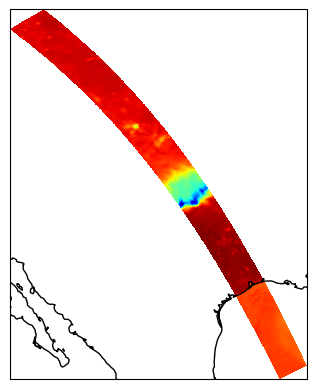

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.coastlines()
ax.pcolormesh(lon,lat,tb_s1_resampled[:,:,8],transform=ccrs.PlateCarree(),cmap='jet')

In [3]:
from pyresample import image, geometry
import lkTables

lookupT=lkTables.scattTables()



<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): dim_0(289), dim_1(8)
    variables(dimensions): float32 kextR(dim_0, dim_1), float32 salbR(dim_0, dim_1), float32 asymR(dim_0, dim_1), float32 kextS(dim_0, dim_1), float32 salbS(dim_0, dim_1), float32 asymS(dim_0, dim_1), float32 kextG(dim_0, dim_1), float32 salbG(dim_0, dim_1), float32 asymG(dim_0, dim_1)
    groups: 


In [4]:
import rtlib
#print(dir(rtlib))

['__doc__', '__f2py_numpy_version__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__version__', '_rtlib_error', 'abh2o', 'abliq', 'absn2', 'band', 'banddec', 'bandsol', 'gasabsr98', 'get_wv_extinction', 'multiscatterf', 'multiscatterf2', 'o2abs', 'o2com1', 'radtran', 'swap', 'vapor']


In [42]:
#print(qv[0,:].shape)
#print(press[0,:].shape)

nt=qv.shape[0]
j=24
freqs=[10.65,18.7,23.8,37.0,89.0,166,183.3+3,183.3+7]
hFreqs=[1,1,2,2,3,4,4,5,5,6,6,7,7]
print(len(hFreqs))
print(sfcEmiss.shape)
import tqdm
importlib.reload(rtlib)
kext_gases=np.zeros((nt,49,78,8))
temp_layer=np.zeros((nt,49,79))
for i in tqdm.tqdm(range(0,nt)):
    for j in range(0,49):
        n5=envNodes[i,j,:]
        press1d=np.interp(range(10,88),n5,press[i,j,:])
        qv1d=np.interp(range(10,88),n5,qv[i,j,:])
        temp1d=np.interp(range(10,88),n5,airTemp[i,j,:])
        temp_layer1d=np.interp(np.arange(9.5,88.5,1),n5,airTemp[i,j,:])
        qv1d[qv1d<1e-3]=1e-3
        rho1d=press1d/(287.05*temp1d)*1e2
        ireturn=0
        #for k,qv1 in enumerate(qv1d):
        #    rhowv1d=rho1d*qv1d*1e-3
        #    for f in freqs:
        #        kext_wv=rtlib.gasabsr98(f,temp1d[k],rhowv1d,press1d[k]*1e2,ireturn)
        rhowv1d=rho1d*qv1d*1e-3
        kext = rtlib.get_wv_extinction(np.array(freqs),temp1d,rhowv1d,press1d*1e2)
        kext_gases[i,j,:]=kext.T
        temp_layer[i,j,:]=temp_layer1d


13
(744, 49, 13)


  0%|          | 0/744 [00:00<?, ?it/s]

100%|██████████| 744/744 [00:11<00:00, 64.22it/s]


In [37]:

a=np.nonzero(pType>0)
print(len(a[0]))
from bisectm import bisectm
kext3d=np.zeros((nt,49,88,8))
salb3d=np.zeros((nt,49,88,8))
asym3d=np.zeros((nt,49,88,8))
for i,j in tqdm.tqdm(zip(a[0],a[1])):
    pwc1=pwc[i,j,:]
    a0=np.nonzero(pwc1>0)
    #print(a0[0])
    #print(binNodes[i,j,:])
    for k in a0[0]:
        dm1=dm[i,j,k]
        if k<=binNodes[i,j,3]:
            iphase=0
            if pType[i,j]!=2:
                ind=bisectm(lookupT.dms.data, 253, dm1)
                dns=np.log10(pwc[i,j,k]/lookupT.swc[ind])
                kext_snow=lookupT.kextS[ind,:]*10**dns
                salb_snow=lookupT.salbS[ind,:]
                asym_snow=lookupT.asymS[ind,:]
            else:
                ind=bisectm(lookupT.dmg.data, 272, dm1)
                dng=np.log10(pwc[i,j,k]/lookupT.gwc[ind])
                kext_snow=lookupT.kextL[ind,:]*10**dng
                salb_snow=lookupT.salbG[ind,:]
                asym_snow=lookupT.asymG[ind,:]
        
        if k>binNodes[i,j,1]:
            ind=bisectm(lookupT.dmr.data, 289, dm1)
            #print(ind,pwc[k])
            dnr=np.log10(pwc[i,j,k]/lookupT.rwc[ind])
            kext_rain=lookupT.kextR[ind,:]*10**dnr
            salb_rain=lookupT.salbR[ind,:]
            asym_rain=lookupT.asymR[ind,:]
        if k<=binNodes[i,j,1]:
            kext=kext_snow
            salb=salb_snow
            asym=asym_snow
        else:
            if k<binNodes[i,j,3]:
                f=(k-binNodes[i,j,1])/(binNodes[i,j,3]-binNodes[i,j,1])
                kext=kext_snow*(1-f)+kext_rain*f
                salb=(salb_snow*(1-f)*kext_snow+salb_rain*f*kext_rain)
                asym=(asym_snow*(1-f)*kext_snow*asym_snow+asym_rain*f*kext_rain*asym_rain)/salb
                salb=salb/kext
            else:
                kext=kext_rain
                salb=salb_rain
                asym=asym_rain
        kext3d[i,j,k,:]=kext
        salb3d[i,j,k,:]=salb
        asym3d[i,j,k,:]=asym     
        if k==a0[0][-1]:
            #print(k,binNodes[i,j,-1],sfcBin[i,j])
            kext3d[i,j,k+1:,:]=kext_rain
            salb3d[i,j,k+1:,:]=salb_rain
            asym3d[i,j,k+1:,:]=asym_rain


5139


5139it [00:08, 579.59it/s] 


In [27]:
print(lookupT.dms.shape)
print(dm1)
print(kext_rain.shape)

(253,)
0.72212756
(8,)


In [8]:
print(kext.shape)

(8, 78)


In [66]:
import netCDF4 as nc
with nc.Dataset('Data/2A-ENV.GPM.DPR.V9-20211125.20180625-S041042-E054316.024557.V07A.HDF5') as f:
    qv_env=f['FS/VERENV/waterVapor'][4500:5500,:,:]
    press_env=f['FS/VERENV/airPressure'][4500:5500,:,:]
    lon_env=f['FS/Longitude'][4500:5500,:]
    lat_env=f['FS/Latitude'][4500:5500,:]

print(qv.shape)

(744, 49, 10)


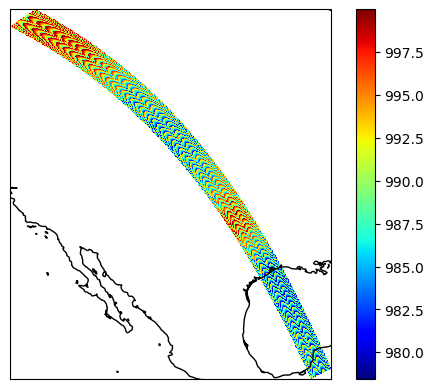

In [67]:
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
plt.pcolormesh(lon_env,lat_env,press_env[:,:,-1],cmap='jet')

ax.coastlines()
plt.colorbar()